<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to discuss how to interpret (and explain) a GP model.


One of the key benefits of a GP based model (for classification or regression) is its ability to model the non-linear relationship between the input covariates and the target, without imposing strong assumptions on the nature of the relationship. However, as is true for any non-linear models, this flexibility results in the lack of interpretability of the GP model.

For instance, consider the problem of predicting house prices, given various features about a house in the `Boston Housing Dataset`

In [89]:
%run Utilities.ipynb
from sklearn.preprocessing import StandardScaler
import time

In [64]:
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT']

In [23]:
boston_data = GPy.util.datasets.boston_housing()
X,y = boston_data['X'],boston_data['Y']
ss = StandardScaler()
Xnorm = ss.fit_transform(X)
inds = np.random.permutation(Xnorm.shape[0])
train_size = 400
Xtrain,ytrain,Xtest,ytest = Xnorm[inds[0:train_size],:],y[inds[0:train_size],:],Xnorm[inds[train_size:],:],y[inds[train_size:],:]

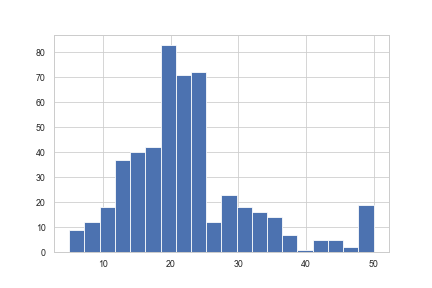

In [39]:
# this is the distribution of the target
h = plt.hist(y,bins=20)

We will first train a linear regression model

In [40]:
md_lr = LinearRegression()
md_lr.fit(Xtrain,ytrain)
ypredict = md_lr.predict(Xtest)
print('RMSE = {:.2f}'.format(np.sqrt(np.mean((ypredict - ytest)**2))))

RMSE = 4.51


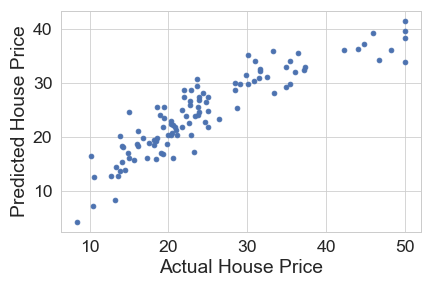

In [44]:
plt.scatter(ytest,ypredict)
plt.xlabel('Actual House Price')
plt.ylabel('Predicted House Price')
plt.tight_layout()

Seems like a decent enough fit. An RMSE of 4.51 for a target that ranges between 0 - 50 could be considered reasonable.
> The target corresponds to the price of the house divided by $1000.

Now let us see if having a non-linear model has a better effect.

In [90]:
st = time.time()
md_gp = GPy.models.GPRegression(Xtrain,ytrain,kernel=GPy.kern.RBF(Xtrain.shape[1]))
md_gp.optimize()
ypredict = md_gp.predict(Xtest)
en = time.time()
print('RMSE = {:.2f}'.format(np.sqrt(np.mean((ypredict[0] - ytest)**2))))
print('Time taken = {:.2f} seconds'.format(en-st))

RMSE = 2.93
Time taken = 0.86 seconds


In [123]:
md_gp

GP_regression.,value,constraints,priors
rbf.variance,511.28732378421313,+ve,
rbf.lengthscale,4.579718385079653,+ve,
Gaussian_noise.variance,6.130229589762804,+ve,


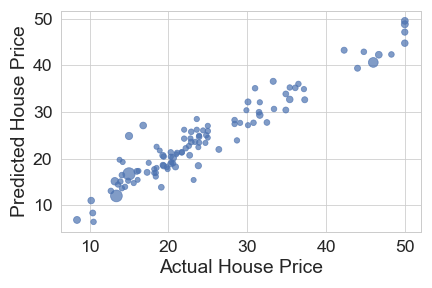

In [52]:
plt.scatter(ytest,ypredict[0],s=4*ypredict[1],alpha=0.7)
plt.xlabel('Actual House Price')
plt.ylabel('Predicted House Price')
plt.tight_layout()

Looks much better. Besides the significantly lower RMSE, the GP models offers an additional output - the variance associated with each output, denoted by the size of the circles in the scatter plot.

But what about interpretability. It is very easy to interpret the linear model, as you can see below where we plot the model coefficients. Generally the model makes sense.

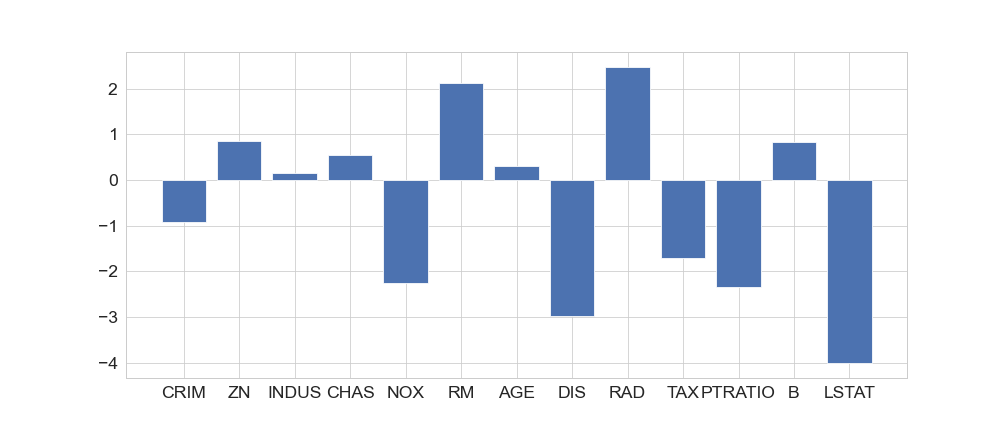

In [87]:
fig = plt.figure(figsize=(14,6))
ax = plt.subplot(111)
ax.bar(np.array(np.arange(13)),md_lr.coef_.flatten())
ax.set_xticks(np.array(np.arange(13)))
xn = ax.set_xticklabels(names)

$$
k({\bf x},{\bf x}') = \sigma^2_f\exp{(-\frac{1}{2\ell}(\Vert{\bf x}-{\bf x}')\Vert_2^2)}
$$
$$
k({\bf x},{\bf x}') = \sigma^2_f\exp{(-\frac{1}{2\ell}\sum_{i=1}^D(x_i - x'_i)^2)}
$$
$$
k({\bf x},{\bf x}') = \sigma^2_f\exp{(-\frac{1}{2}\sum_{i=1}^D\frac{(x_i - x'_i)^2}{\ell_i}})
$$

On the other hand, the GP model does not offer any such interpretability, in its present form.

### Automatic Relevance Determination
*Automatic Relevance Determination* or ARD, is a way to infer relevance of the different features in a GP based model. There are several ways to do ARD. For stationary kernels, where the covariance function depends only on the difference between the two vectors, once can perform ARD by choosing a different lengthscale for each feature in the input vector. For instance, the SE kernel with ARD can be calculated as:
$$
k({\bf x},{\bf x}') = \sigma^2_f\exp{(-\frac{1}{2}({\bf x}-{\bf x}')^\top M ({\bf x}-{\bf x}'))}
$$
where $M$ is a diagonal matrix, i.e., $M = diag(\frac{1}{\bf l})$. The $D$-length vector ${\bf l}$ can be used to determine the relevance of each feature, as:
$$
r_i = \frac{1}{{\bf l}[i]}
$$
> The above result can be obtained from the fact that if the lengthscale for any feature is small, then the covariance along the corresponding dimension will change very fast. On the other hand a larger lengthscale would mean that the covariance is not very sensitive to that feature.

In `GPy` a stationary kernel (RBF, Matern32, etc.) can be turned into an ARD kernel, by using `ARD = True` flag.

In [91]:
st = time.time()
md_gp_ard = GPy.models.GPRegression(Xtrain,ytrain,kernel=GPy.kern.RBF(Xtrain.shape[1],ARD=True))
md_gp_ard.optimize()
ypredict = md_gp_ard.predict(Xtest)
en = time.time()
print('RMSE = {:.2f}'.format(np.sqrt(np.mean((ypredict[0] - ytest)**2))))
print('Time taken = {:.2f} seconds'.format(en-st))

RMSE = 3.12
Time taken = 6.53 seconds


In [124]:
md_gp_ard

GP_regression.,value,constraints,priors
rbf.variance,699.2961921616991,+ve,
rbf.lengthscale,"(14,)",+ve,
Gaussian_noise.variance,4.287432213596658,+ve,


The RMSE is not very worse than the regular GPR, and can be improved with using more data, a better kernel, etc. The time is much longer, since now there are many more hyper-parameters to be trained. 

In [102]:
relvec = 1/np.array(md_gp_ard.kern.lengthscale)

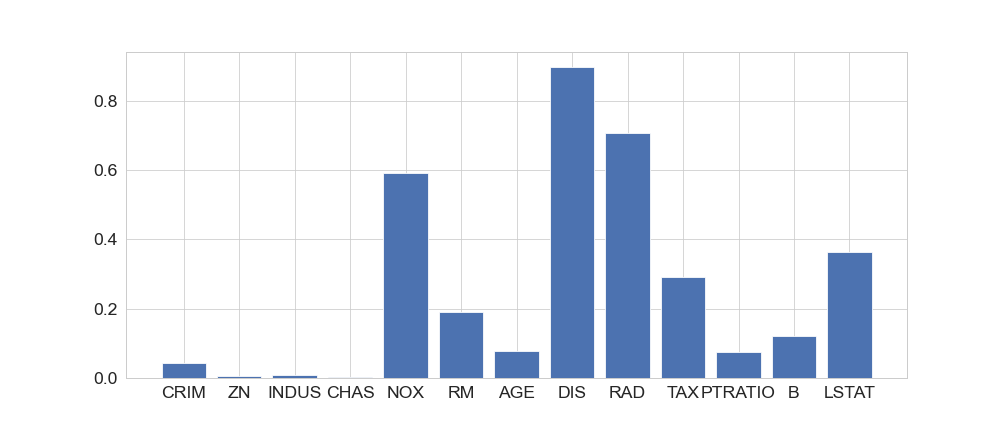

In [113]:
fig = plt.figure(figsize=(14,6))
ax = plt.subplot(111)
ax.bar(np.array(np.arange(13)),relvec)
ax.set_xticks(np.array(np.arange(13)))
xn = ax.set_xticklabels(names)

> Notice that the relevance vector obtained from ARD does not give us the "direction" of the relevance.

Additionally, the relevance vector values are _uncalibrated_. We do not know if a value of 0.3 is low or high. One "hack" to handle that could be to add a completely random vector as a dummy feature and use its relevance as the baseline to find the significance of the relevance values.


In [111]:
Xaug = np.hstack((X,np.random.normal(0,1,(X.shape[0],1))))
ss = StandardScaler()
Xnorm = ss.fit_transform(Xaug)
inds = np.random.permutation(Xnorm.shape[0])
train_size = 400
Xtrain,ytrain,Xtest,ytest = Xnorm[inds[0:train_size],:],y[inds[0:train_size],:],Xnorm[inds[train_size:],:],y[inds[train_size:],:]

In [112]:
st = time.time()
md_gp_ard = GPy.models.GPRegression(Xtrain,ytrain,kernel=GPy.kern.RBF(Xtrain.shape[1],ARD=True))
md_gp_ard.optimize()
ypredict = md_gp_ard.predict(Xtest)
en = time.time()
print('RMSE = {:.2f}'.format(np.sqrt(np.mean((ypredict[0] - ytest)**2))))
print('Time taken = {:.2f} seconds'.format(en-st))

RMSE = 2.83
Time taken = 13.30 seconds


In [114]:
relvec = 1/np.array(md_gp_ard.kern.lengthscale)

In [121]:
relvec_adj = relvec[0:13]/relvec[-1]

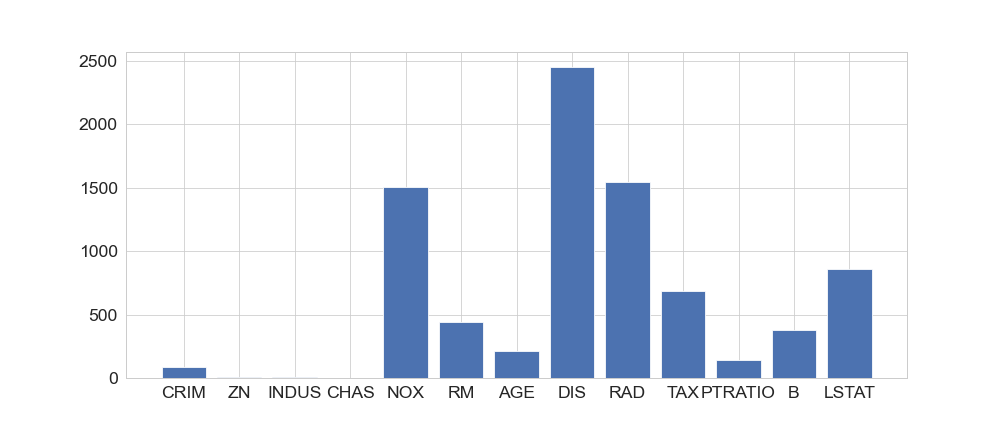

In [122]:
fig = plt.figure(figsize=(14,6))
ax = plt.subplot(111)
ax.bar(np.array(np.arange(13)),relvec_adj)
ax.set_xticks(np.array(np.arange(13)))
xn = ax.set_xticklabels(names)

$$
k({\bf x},{\bf x}') = \sum_{i=1}^D k_i(x_i,x_i^i)
$$
$$
f({\bf  x}) = \sum_{i=1}^Df_i(x_i)
$$